# Unitary_propagator time step demo

In [1]:
using QSimulator
using PyPlot

import LinearAlgebra: eigvecs, eigen, tr
import QSimulator: eye

In [2]:
q1 = Qubit("q1", 4.0)

drive = MicrowaveControl("drive1", 4.0, timeStep = 1.0)
seq = ones(200)
load_sequence!(drive, seq)

sys = q1 + SemiClassicalDipole(Field(drive), q1, 0.01);

In [ ]:
# define the initial state
rhoIn = zeros(ComplexF64, dim(sys), dim(sys))
rhoIn[1] = 1;
#define the measurement projector
evecs = eigvecs(hamiltonian(sys))
measOp = evecs[:,2] * evecs[:,2]'
real(measOp)

In [4]:
# Same function as in Blake's talk but I'm actively updating rho in the loop
function run_simulation(sys, rhoIn, measOp, times)
    populations = zeros(length(times)-1)
    U = eye(ComplexF64, dim(sys))
    dt = 0.01
    rho = rhoIn
    for ct = 1:length(times)-1
        U = unitary_propagator(sys, dt, times[ct], times[ct+1])
        populations[ct] = real(tr(U*rho*U'*measOp))
        rho = U*rho*U'
    end
    return populations
end

run_simulation (generic function with 1 method)

In [ ]:
times = 0.0:200.0
#timeSteps = [1., 0.1, 0.01]
#pops = zeros(Complex128, length(timeSteps), length(times)-1)

#for (i,dt) in enumerate(timeSteps)
#    pops[i] = run_simulation(sys, rhoIn, measOp, times, dt);
#end
populations = run_simulation(sys, rhoIn, measOp, times);

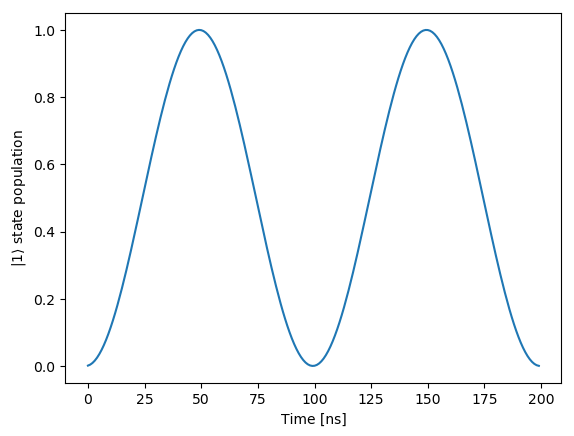

In [6]:
plot(times[1:end-1], populations)
xlabel("Time [ns]")
ylabel(L"$|1\rangle$ state population");

In [7]:
function sim_sweep(rhoIn, measOp, times, freqs)
    q1 = Qubit("q1", 4.0)
    
    populations = zeros(length(times)-1, length(freqs))
    for (ct, f) in enumerate(freqs)
        drive = MicrowaveControl("drive1", f, timeStep=1.0)
        sys = q1 + SemiClassicalDipole(Field(drive), q1, 0.01)
        load_sequence!(drive, ones(Int(times[end])));
        populations[:, ct] = run_simulation(sys, rhoIn, measOp, times)
    end
    return populations
end

sim_sweep (generic function with 1 method)

In [8]:
rhoIn = ComplexF64[1 0; 0 0]
measOp = ComplexF64[0 0; 0 1]
times = 0.0:4.0:200.0
freqs = 3.97:0.001:4.03
population_sweep = sim_sweep(rhoIn, measOp, times, freqs);

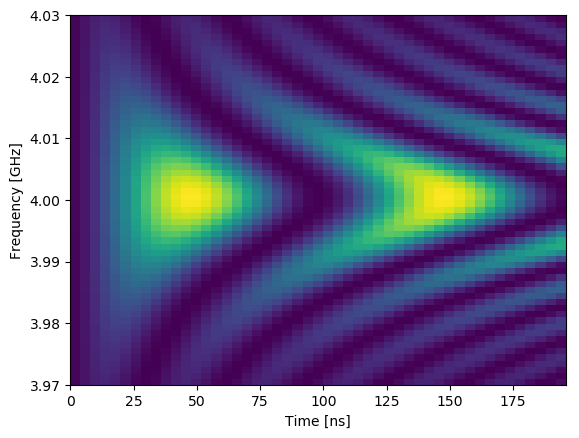

PyObject Text(24.000000000000007, 0.5, 'Frequency [GHz]')

In [9]:
pcolormesh(times[1:end-1], freqs, population_sweep')
xlabel("Time [ns]")
ylabel("Frequency [GHz]")